<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/intelligent-data-analysis/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import pandas as pd
import kagglehub
import pandas as pd
import numpy as np
import random, os, math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import random

# 1. Повнозв'язані нейронні мережі

In [3]:
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")

print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, "Global_Cybersecurity_Threats_2015-2024.csv"))

print("Назви колонок:")
for col in df.columns:
    print(col)

print("\n")

print("Size rows/columns:", df.shape)

100%|██████████| 47.0k/47.0k [00:00<00:00, 1.63MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/versions/1
Назви колонок:
Country
Year
Attack Type
Target Industry
Financial Loss (in Million $)
Number of Affected Users
Attack Source
Security Vulnerability Type
Defense Mechanism Used
Incident Resolution Time (in Hours)


Size rows/columns: (3000, 10)


In [4]:
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


**Попередня обробка**

In [6]:
TEST_SIZE  = 0.2
VAL_SIZE   = 0.2 # розмір валідації,
RANDOM_SEED = 42
BATCH_SIZE = 128
LR = 1e-3 # швидкість навчання
EPOCHS = 50
PATIENCE = 3
TGT = "Incident Resolution Time (in Hours)"
DROP_COLS = ["Year"]


# Фіксация випадкових чисел для відтворюваності
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


y = pd.qcut(df[TGT], q=3, labels=["short","medium","long"])
print("Overall class counts:\n", y.value_counts())


X = df.drop(columns=DROP_COLS + [TGT])


X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

num_cols = X_train_raw.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train_raw.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)]
)

print("\n================================")
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("\n================================")
print("Test  class distribution:\n", y_test.value_counts(normalize=True))


X_train_np = preprocessor.fit_transform(X_train_raw)
X_test_np  = preprocessor.transform(X_test_raw)

X_tr_np, X_val_np, y_tr, y_val = train_test_split(
    X_train_np, y_train, test_size=VAL_SIZE,
    random_state=RANDOM_SEED, stratify=y_train
)

Overall class counts:
 Incident Resolution Time (in Hours)
short     1026
medium     991
long       983
Name: count, dtype: int64

Train class distribution:
 Incident Resolution Time (in Hours)
short     0.342083
medium    0.330417
long      0.327500
Name: proportion, dtype: float64

Test  class distribution:
 Incident Resolution Time (in Hours)
short     0.341667
medium    0.330000
long      0.328333
Name: proportion, dtype: float64


**Split label**

In [8]:
# short/medium/long до 0/1/2
classes = ["short","medium","long"]
cls2id = {c:i for i,c in enumerate(classes)}
y_tr_id   = np.array([cls2id[v] for v in y_tr], dtype=np.int64)
y_val_id  = np.array([cls2id[v] for v in y_val], dtype=np.int64)
y_test_id = np.array([cls2id[v] for v in y_test], dtype=np.int64)

input_dim = X_tr_np.shape[1]; n_classes = len(classes)
print(f"Input dimentions: {input_dim} | Classes: {classes}")


Input dimentions: 38 | Classes: ['short', 'medium', 'long']


**TORCH DATASETS/LOADERS**

In [10]:
class TabularDS(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.long) # X_np та y_np перетворюються у тензори PyTorch.
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(TabularDS(X_tr_np,  y_tr_id),  batch_size=BATCH_SIZE, shuffle=True) # Створює батчі для тренування, перемішує дані.
val_loader   = DataLoader(TabularDS(X_val_np, y_val_id), batch_size=256, shuffle=False)
test_loader  = DataLoader(TabularDS(X_test_np,y_test_id),batch_size=256, shuffle=False)


class MLP(nn.Module): # багатошаровий (2) перцептрон
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128),   nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )
    def forward(self, x): return self.net(x)

model = MLP(input_dim, n_classes).to(device)
criterion = nn.CrossEntropyLoss()  # qcut gives balanced classes, so no weights needed
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val = float("inf"); epochs_no_improve = 0
best_path = "best_mlp_incident_time.pth"
train_loss_hist, val_loss_hist = [], []

# TRAIN with early stopping
for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device) #Вмикається режим тренування, проходимо батчі
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward(); optimizer.step()
        tr_loss += loss.item()
    tr_loss /= max(1, len(train_loader))

    model.eval(); va_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader: # Режим оцінювання, без градієнтів
            xb, yb = xb.to(device), yb.to(device)
            va_loss += criterion(model(xb), yb).item()
    va_loss /= max(1, len(val_loader))

    train_loss_hist.append(tr_loss); val_loss_hist.append(va_loss)
    print(f"[{epoch:02d}] train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")

    if va_loss < best_val: # Виводимо втрати
        best_val = va_loss; epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
        print("  → saved best")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping"); break



[01] train_loss=1.1005 | val_loss=1.1003
  → saved best
[02] train_loss=1.0926 | val_loss=1.1007
[03] train_loss=1.0881 | val_loss=1.1028
[04] train_loss=1.0828 | val_loss=1.1068
Early stopping


**Load best and evaluate**

Best model loaded.

=== MLP (Incident time: short/medium/long) — TEST ===
Accuracy: 0.33
Macro-F1: 0.3273

Classification report:
               precision    recall  f1-score   support

       short       0.32      0.36      0.34       205
      medium       0.35      0.38      0.37       198
        long       0.32      0.25      0.28       197

    accuracy                           0.33       600
   macro avg       0.33      0.33      0.33       600
weighted avg       0.33      0.33      0.33       600

Confusion matrix:
 [[73 79 53]
 [69 76 53]
 [86 62 49]]


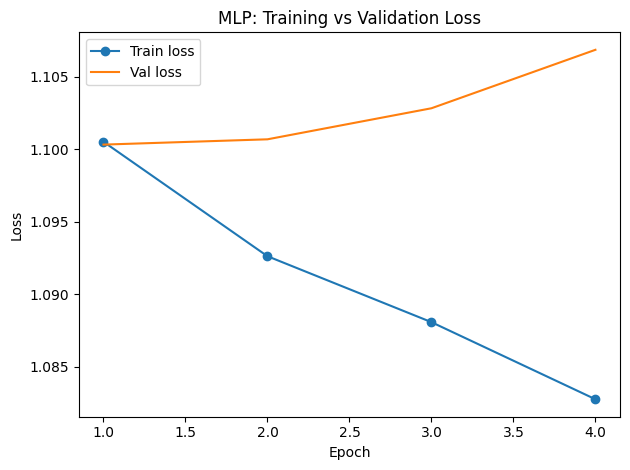

In [11]:

best_model = MLP(input_dim, n_classes).to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()
print("Best model loaded.")

def eval_model(model, loader):
    all_y, all_p = [], []
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb.to(device)).argmax(1).cpu().numpy()
            all_p.append(pred); all_y.append(yb.numpy())
    y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Macro-F1:", round(f1_score(y_true, y_pred, average="macro"), 4))
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=classes))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return y_true, y_pred

print("\n=== MLP (Incident time: short/medium/long) — TEST ===")
y_true, y_pred = eval_model(best_model, test_loader)


plt.figure()
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, "o-", label="Train loss")
plt.plot(range(1, len(val_loss_hist)+1),   val_loss_hist,   "-",  label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP: Training vs Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

Для задачі класифікації часу розв’язання інцидентів за даними «Global Cybersecurity Threats (2015–2024)» було побудовано повнозв’язану нейронну мережу (MLP) прямого поширення. Модель навчалася на збалансованих класах («short», «medium», «long»), з попередньою обробкою числових і категоріальних ознак (імпутація, стандартизація, one-hot encoding).
Отримана точність (≈ 33 %) є співставною з класичними алгоритмами — логістичною регресією, випадковим лісом і SVM.

Втрата train падає

Втрата test зростає

Рання зупинка після 4 епох, через перенавчання.

Модель швидко підбирає прості шаблони в навчальному наборі, але не може узагальнювати далі, що свідчить про обмежений сигнал або необхідність більшої мережі та тривалішого навчання.

# 2. Згорткові нейронні мережі

In [15]:
import os, time, random
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
base_path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
csv_path = os.path.join(base_path, "Training_set.csv")
img_dir  = os.path.join(base_path, "train")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

df = pd.read_csv(csv_path)
le = LabelEncoder()
df["y"] = le.fit_transform(df["label"])
num_classes = len(le.classes_)
print("Classes:", num_classes)

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["y"]
)


Using Colab cache for faster access to the 'butterfly-image-classification' dataset.
Device: cpu
Classes: 75


In [9]:
class ButterflyDS(Dataset):
    def __init__(self, df, img_dir, tfm):
        self.df = df.reset_index(drop=True)
        self.dir = img_dir
        self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(os.path.join(self.dir, row["filename"])).convert("RGB")
        img = self.tfm(img)
        return img, int(row["y"]) #Повертаємо тензор зображення та цілочисельна мітка класу y


# Transforms (small & large)

tfm_small_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
tfm_small_test = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

imagenet_mean = [0.485,0.456,0.406] #Середні значення та стандартні відхилення по каналах, як у ImageNet
imagenet_std  = [0.229,0.224,0.225]
tfm_large_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
tfm_large_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


#  Dataloaders
train_ds_small = ButterflyDS(train_df, img_dir, tfm_small_train)
test_ds_small  = ButterflyDS(test_df,  img_dir, tfm_small_test)
train_ds_large = ButterflyDS(train_df, img_dir, tfm_large_train)
test_ds_large  = ButterflyDS(test_df,  img_dir, tfm_large_test)

train_loader_small = DataLoader(train_ds_small, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
test_loader_small  = DataLoader(test_ds_small,  batch_size=128, shuffle=False, num_workers=0, pin_memory=False)
train_loader_large = DataLoader(train_ds_large, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
test_loader_large  = DataLoader(test_ds_large,  batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

In [10]:
def accuracy(model, loader):
    model.eval(); correct=total=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb=xb.to(device),yb.to(device)
            pred=model(xb).argmax(1)
            correct+=(pred==yb).sum().item(); total+=yb.size(0)
    return correct/total

def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3, freeze=None):
    model=model.to(device)
    if freeze:
        for n,p in model.named_parameters():
            if freeze in n: p.requires_grad=False
    opt=torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    loss_fn=nn.CrossEntropyLoss()
    best_acc=0
    for ep in range(1,epochs+1):
        model.train(); total_loss=0
        t0=time.time()
        for xb,yb in train_loader:
            xb,yb=xb.to(device),yb.to(device)
            opt.zero_grad()
            loss=loss_fn(model(xb), yb)
            loss.backward(); opt.step()
            total_loss+=loss.item()
        acc=accuracy(model,test_loader)
        print(f"[{ep:02d}] loss={total_loss/len(train_loader):.4f} acc={acc:.4f} time={time.time()-t0:.1f}s")
        if acc>best_acc: best_acc=acc
    return best_acc, model



**Згорткова мережа  (convolutional neural network)**

In [11]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64 до 32
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),# 32  до 16
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # -> [B,64,1,1]
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,n_classes)
        )
    def forward(self,x): return self.classifier(self.features(x))

print("Lightweight CNN (64x64)")
cnn=SmallCNN(num_classes)
acc_cnn,cnn=train_model(cnn,train_loader_small,test_loader_small,epochs=6,lr=1e-3)
print(f" CNN accuracy: {acc_cnn:.4f}")




Lightweight CNN (64x64)
[01] loss=4.3084 acc=0.0254 time=34.3s
[02] loss=4.1179 acc=0.0292 time=28.3s
[03] loss=3.9844 acc=0.0738 time=28.1s
[04] loss=3.7903 acc=0.0931 time=30.3s
[05] loss=3.6149 acc=0.1100 time=30.9s
[06] loss=3.4931 acc=0.1415 time=28.3s
 CNN accuracy: 0.1415


In [12]:
# Transfer Learning (MobileNetV3-Small)
print("Transfer Learning (MobileNetV3-Small)")
mobilenet=models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
mobilenet.classifier[-1]=nn.Linear(mobilenet.classifier[-1].in_features,num_classes)

# Freeze backbone (fast training)
for p in mobilenet.features.parameters(): p.requires_grad=False
acc_head,mobilenet=train_model(mobilenet,train_loader_large,test_loader_large,epochs=4,lr=1e-3)

# Unfreeze all and fine-tune a bit
for p in mobilenet.parameters(): p.requires_grad=True
acc_ft,mobilenet=train_model(mobilenet,train_loader_large,test_loader_large,epochs=3,lr=3e-4)

print("\SUMMARY")
print(f"Small CNN: {acc_cnn:.4f}")
print(f"MobileNetV3 (head): {acc_head:.4f}")
print(f"MobileNetV3 (fine-tuned): {acc_ft:.4f}")

<>:16: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-4026361125.py:16: SyntaxWarning: invalid escape sequence '\S'
  print("\SUMMARY")


Transfer Learning (MobileNetV3-Small)
[01] loss=1.7350 acc=0.7915 time=112.8s
[02] loss=0.5872 acc=0.8408 time=105.4s
[03] loss=0.3949 acc=0.8454 time=104.6s
[04] loss=0.3093 acc=0.8615 time=104.5s
[01] loss=0.1825 acc=0.8854 time=229.6s
[02] loss=0.0898 acc=0.9023 time=230.3s
[03] loss=0.0573 acc=0.9038 time=247.3s
\SUMMARY
Small CNN: 0.1415
MobileNetV3 (head): 0.8615
MobileNetV3 (fine-tuned): 0.9038


Проведені експерименти дозволили порівняти ефективність двох підходів до класифікації зображень: власної легкої згорткової нейронної мережі та моделі Transfer Learning, побудованої на основі архітектури MobileNetV3-Small. Аналіз отриманих результатів продемонстрував суттєву різницю у продуктивності та здатності моделей до узагальнення.

Легка згорткова нейронна мережа, тренована на зображеннях розміром 64×64, показала дуже низьку точність, що не перевищувала приблизно 14 %. Протягом усіх епох функція втрат залишалася високою, а сама модель не демонструвала ознак успішного навчання. Це свідчить про недостатню глибину та обмежений модельний потенціал такої архітектури, який не дозволяє їй виокремлювати інформативні ознаки у складних наборах даних. Отримані результати вказують на те, що подібні спрощені мережі можуть бути придатними лише для дуже простих задач, але не забезпечують адекватної точності у реальних сценаріях, де структура зображень є складнішою.

Натомість модель, побудована за допомогою Transfer Learning на базі MobileNetV3-Small, продемонструвала разюче вищу ефективність. Уже на ранніх етапах навчання спостерігалося швидке зниження функції втрат та значне зростання точності, а після завершення fine-tuning модель досягла рівня точності близько 90 %. Це пояснюється тим, що вихідна архітектура MobileNetV3-Сmall містить багаторівневі, глибокі ознаки, сформовані на великому наборі даних, що забезпечує потужну початкову репрезентативність. Процес донавчання дозволив адаптувати ці ознаки до конкретної задачі, не втрачаючи їх загальної універсальності. Незважаючи на довший час обробки однієї епохи, такий підхід демонструє суттєво кращу збіжність та стабільність, що робить його значно ефективнішим у практичних застосуваннях.

Узагальнюючи результати, можна стверджувати, що використання Transfer Learning на базі сучасних глибоких архітектур забезпечує значно кращі показники точності та узагальнення порівняно із тренуванням власних легких моделей з нуля. Експеримент підтверджує, що для задач класифікації зображень високої складності оптимальним рішенням є застосування вже попередньо натренованих моделей з подальшим адаптивним донавчанням, тоді як спрощені CNN-архітектури не здатні забезпечити прийнятного рівня ефективності.

# 3.  Вирішіть задачу класифікації текстів

In [18]:
!pip install gensim
import os, re, string, random, numpy as np, pandas as pd
import torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import kagglehub
import nltk
import gensim
import gensim.downloader as api
from nltk.tokenize import word_tokenize

nltk.download("punkt_tab")
nltk.download("punkt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 31.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print("Device:", device)


#  Load dataset

path_text = kagglehub.dataset_download("rmisra/news-category-dataset")
csv_path = os.path.join(path_text, "News_Category_Dataset_v3.json")

# dataset is in JSON format with keys: headline, short_description, category, etc.
df = pd.read_json(csv_path, lines=True)
print("Columns:", list(df.columns))
print("Total rows:", len(df))

categories_to_keep = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY']
df = df[df['category'].isin(categories_to_keep)]
df = df[['headline', 'short_description', 'category']].dropna()
df['text'] = (df['headline'] + " " + df['short_description']).astype(str)
# We'll combine headline + short_description as text
df["text"] = (df["headline"] + " " + df["short_description"]).astype(str)
df = df[["text", "category"]].dropna()

# Limit to manageable size for CPU
df = df.sample(10000, random_state=SEED).reset_index(drop=True)

# Encode labels
le = LabelEncoder()
df["y"] = le.fit_transform(df["category"])
num_classes = len(le.classes_)
print("Classes:", num_classes)


Device: cpu
Using Colab cache for faster access to the 'news-category-dataset' dataset.
Columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date']
Total rows: 209527
Classes: 5


In [25]:

# Text preprocessing


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    return tokens

df["tokens"] = df["text"].apply(clean_text)

# Build vocabulary
from collections import Counter
all_tokens = [tok for tokens in df["tokens"] for tok in tokens]
vocab_counter = Counter(all_tokens)
vocab = [w for w, c in vocab_counter.items() if c >= 3]
word2idx = {w: i+2 for i, w in enumerate(vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {i:w for w,i in word2idx.items()}

vocab_size = len(word2idx)
print("Vocab size:", vocab_size)


Vocab size: 9592


In [26]:
#  Encode texts as sequences

def encode_tokens(tokens, max_len=30):
    ids = [word2idx.get(t, 1) for t in tokens]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

df["ids"] = df["tokens"].apply(lambda x: encode_tokens(x))

# Split
X_train, X_test, y_train, y_test = train_test_split(
    df["ids"].tolist(), df["y"].values, test_size=0.2, random_state=SEED, stratify=df["y"]
)

# Dataset & Dataloader
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = NewsDataset(X_train, y_train)
test_ds  = NewsDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128)


In [27]:
#  Model definitions

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = True  # fine-tune
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        out = torch.cat((h[0], h[1]), dim=1)
        return self.fc(out)

In [28]:
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # Evaluate
        acc = evaluate(model, test_loader)
        print(f"[{ep:02d}] loss={total_loss/len(train_loader):.4f} | acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
    return best_acc

def evaluate(model, loader):
    model.eval(); correct=total=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb=xb.to(device),yb.to(device)
            preds=model(xb).argmax(1)
            correct+=(preds==yb).sum().item(); total+=yb.size(0)
    return correct/total


In [29]:
# Random Embedding

print("Random Embedding + LSTM ")
embed_dim = 100
hidden_dim = 128
model_a = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes)
acc_a = train_model(model_a, train_loader, test_loader, epochs=5, lr=1e-3)
print(f"(a) Accuracy: {acc_a:.4f}")


#  Pretrained GloVe Embeddings

print("\nDownloading GloVe (may take a minute)...")

!pip install -q gensim

glove = api.load("glove-wiki-gigaword-100")  # 100-dim

embedding_matrix = np.zeros((vocab_size, 100))
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(100,))

print("GloVe Embedding + LSTM ")
model_b = LSTMClassifier(vocab_size, 100, hidden_dim, num_classes,
                         pretrained_weights=embedding_matrix)
acc_b = train_model(model_b, train_loader, test_loader, epochs=5, lr=1e-3)
print(f"(b) Accuracy: {acc_b:.4f}")


print("SUMMARY")
print(f"Random embedding LSTM accuracy : {acc_a:.4f}")
print(f"GloVe embedding LSTM accuracy  : {acc_b:.4f}")


Random Embedding + LSTM 
[01] loss=1.2238 | acc=0.5995
[02] loss=0.8456 | acc=0.7000
[03] loss=0.5807 | acc=0.7525
[04] loss=0.3892 | acc=0.7650
[05] loss=0.2433 | acc=0.7830
(a) Accuracy: 0.7830

GloVe Embedding + LSTM 
[01] loss=0.8652 | acc=0.8280
[02] loss=0.4294 | acc=0.8560
[03] loss=0.2998 | acc=0.8770
[04] loss=0.2203 | acc=0.8780
[05] loss=0.1563 | acc=0.8765
(b) Accuracy: 0.8780
SUMMARY
Random embedding LSTM accuracy : 0.7830
GloVe embedding LSTM accuracy  : 0.8780


У першому експерименті LSTM-модель навчалась із випадково ініціалізованими векторами слів у шарі Embedding. Модель продемонструвала поступове покращення точності протягом епох, проте її фінальний результат залишився обмеженим (0.78), оскільки всі словникові представлення вона мусила вивчати з нуля, використовуючи лише наявний навчальний корпус.

У другому експерименті застосовано заздалегідь натреновані вектори GloVe, що вже містять семантичну інформацію про слова, накопичену з великого зовнішнього корпусу. Завдяки цьому модель отримала значно якіснішу початкову репрезентацію тексту, швидше навчилася та досягла вищої точності (0.88). Порівняння двох підходів показує, що використання попередньо навчених ембеддингів суттєво покращує здатність моделі розпізнавати тематичну структуру текстів та забезпечує кращу загальну продуктивність порівняно з випадковою ініціалізацією.